### Introduction


**Probelm Statement:** Make a classifier which takes in a job description and gives the department name for it.
*   Use a neural network model
*   Make use of a pre-trained Word Embeddings (example: Word2Vec, GloVe, etc.)
*   Calculate the accuracy on a test set (data not used to train the model)

**Problem Solving Approach:** 
_Provide a brief description of steps you followed for solving this problem_
1. Its is the classification problem I Solved using multiclass classification analysis.
2. Steps involving the preprocessing text to string sequence conversion for LSTM modeling.
3. Used pretrained word2vec used for vocabulary building LSTM Recurrent neural networks used for the classification.

### Part I: Text Preprocessing

_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

Import neccessary packages in below cell

In [2]:
import pandas as pd
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
import re
from nltk.corpus import stopwords
import gensim, re

In [3]:
new_data=pd.DataFrame()
directory='data/docs'
for filename in os.listdir(directory):
    data_df = pd.read_json(open(directory+"/"+filename, "r"))
    new_data=new_data.append(data_df)
X_train=new_data.loc['description',['_id','jd_information']]
X_train = X_train.rename(columns={'jd_information':'description'})
X_train=X_train.set_index('_id')
y_train=pd.read_csv('data/document_departments.csv')
y_train = y_train.rename(columns={'Document ID':'_id'})
y_train=y_train.set_index('_id')
DATA=X_train.join(y_train)
df=DATA
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['description'] = df['description'].apply(clean_text)
df['description'] = df['description'].str.replace('\d+', '')

### Part II: Exploratoty Data Analysis

_Include EDA steps like finding distribution of Departments in this part, you may also use plots for EDA._

In [4]:
DATA.shape

(1162, 2)

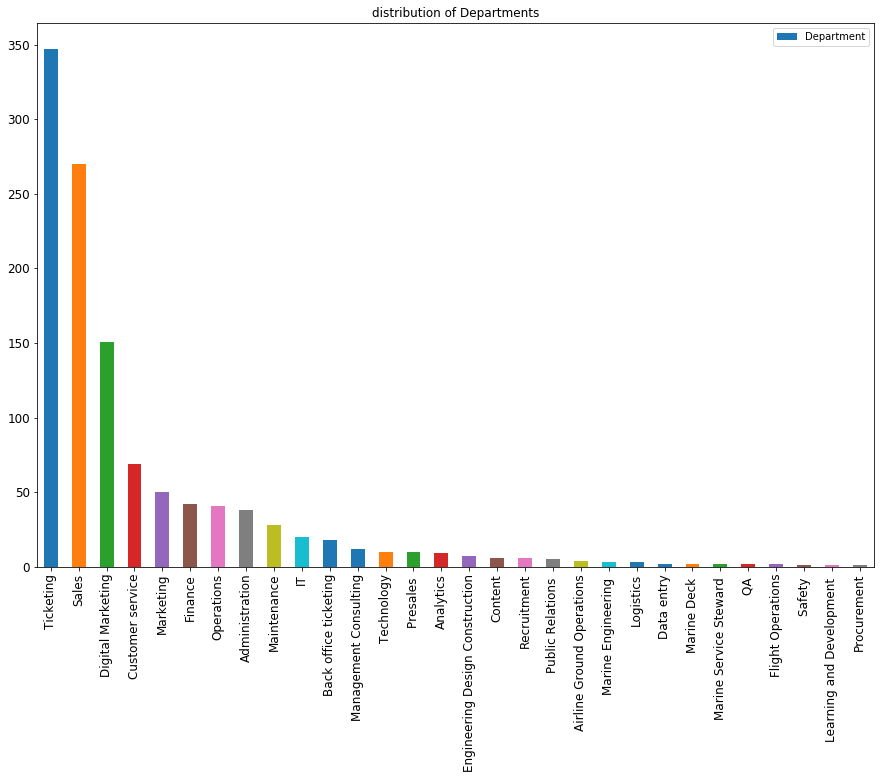

In [5]:
DATA.Department.value_counts().plot(kind='bar', title ="distribution of Departments", figsize=(15, 10), legend=True, fontsize=12)

In [6]:
DATA.Department.value_counts()

Ticketing                          347
Sales                              270
Digital Marketing                  151
Customer service                    69
Marketing                           50
Finance                             42
Operations                          41
Administration                      38
Maintenance                         28
IT                                  20
Back office ticketing               18
Management Consulting               12
Technology                          10
Presales                            10
Analytics                            9
Engineering Design Construction      7
Content                              6
Recruitment                          6
Public Relations                     5
Airline Ground Operations            4
Marine Engineering                   3
Logistics                            3
Data entry                           2
Marine Deck                          2
Marine Service Steward               2
QA                       

### Part III: Modelling & Evaluation

_Include all model prepration & evaluation steps in this part._

In [0]:
word_model = gensim.models.Word2Vec(df['description'].values, size=300, min_count=1, iter=10)
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(word_model.wv.vocab) + 1, 300))
for i, vec in enumerate(word_model.wv.vectors):
    embedding_matrix[i] = vec
    
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = len(word_model.wv.vocab)+1
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7308 unique tokens.


In [0]:

X = tokenizer.texts_to_sequences(df['description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df['Department']).values
print('Shape of label tensor:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


('Shape of data tensor:', (1162, 500))
('Shape of label tensor:', (1162, 30))
((1045, 500), (1045, 30))
((117, 500), (117, 30))


In [0]:
model = Sequential()
model.add(Embedding(len(word_model.wv.vocab)+1,300,input_length=X.shape[1],weights=[embedding_matrix],trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(30, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          9000      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                9030      
Total params: 739,230
Trainable params: 730,230
Non-trainable params: 9,000
_________________________________________________________________
None


In [15]:
epochs = 10
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 940 samples, validate on 105 samples
Epoch 1/10
940/940 [==============================] - 70s 75ms/step - loss: 2.5493 - acc: 0.3245 - val_loss: 1.9481 - val_acc: 0.4000
Epoch 2/10
940/940 [==============================] - 71s 76ms/step - loss: 2.0231 - acc: 0.3904 - val_loss: 1.8680 - val_acc: 0.4476
Epoch 3/10
940/940 [==============================] - 72s 76ms/step - loss: 1.9472 - acc: 0.4160 - val_loss: 1.8610 - val_acc: 0.4190
Epoch 4/10
940/940 [==============================] - 71s 76ms/step - loss: 1.9106 - acc: 0.4340 - val_loss: 1.8374 - val_acc: 0.4762
Epoch 5/10
940/940 [==============================] - 71s 76ms/step - loss: 1.8816 - acc: 0.4085 - val_loss: 1.8359 - val_acc: 0.4667
Epoch 6/10
940/940 [==============================] - 70s 74ms/step - loss: 1.8379 - acc: 0.4277 - val_loss: 1.8115 - val_acc: 0.4857
Epoch 7/10
940/940 [==============================] - 69s 73ms/step - loss: 1.7891 - acc: 0.4521 - val

In [0]:
predicted = model.predict(X , verbose=2)
predicted_labels = predicted.argmax(axis=1)

df['Department']=df['Department'].astype('category')
df['Department']=df['Department'].cat.codes

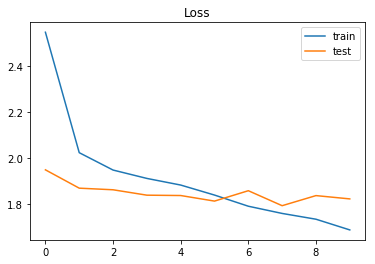

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

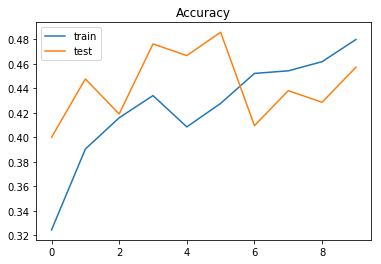

In [18]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print (confusion_matrix(df['Department'].values, predicted_labels))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   6   0  32]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   4]
 [  0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2   0  16]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1   0   5]
 [  0   0   0   0   0   2   0   4   0   0   0   0   0   0   0   0   0   0
    0   0   0   2   0   0   0   0   0   8   0  53]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0 125   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1   0   0   0   2   0  23]


In [20]:
print (classification_report(df['Department'].values, predicted_labels, digits=4 ))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        38
           1     0.0000    0.0000    0.0000         4
           2     1.0000    0.2222    0.3636         9
           3     0.0000    0.0000    0.0000        18
           4     0.0000    0.0000    0.0000         6
           5     0.5000    0.0290    0.0548        69
           6     0.0000    0.0000    0.0000         2
           7     0.8803    0.8278    0.8532       151
           8     0.0000    0.0000    0.0000         7
           9     1.0000    0.0238    0.0465        42
          10     0.0000    0.0000    0.0000         2
          11     0.0000    0.0000    0.0000        20
          12     0.0000    0.0000    0.0000         1
          13     0.0000    0.0000    0.0000         3
          14     0.0000    0.0000    0.0000        28
          15     0.0000    0.0000    0.0000        12
          16     0.0000    0.0000    0.0000         2
          17     0.0000    

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


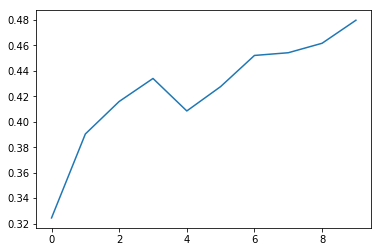

In [26]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history['acc'])
pyplot.show()

**Results Summary:**
_Provide a brief summary of results obtained like model accuracy & other insights based on EDA & your interpretations_

1.Its the inbalance dataset lot of imbalance towards class.
2. History is incresing so we can increase accuracy using defferent preprocessing steps and balancing dataset.
3. F1-SCORE:-Its quite low because of lot of imbalance in data also I didnot get time to improve I can improve.